**<h5></h5>**
**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Fall 2023</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: December 29, 2023 23:59 (GMT+3)</center></h4>

## **CIFAR-100 Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train a convolutional neural network model for the image inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the preprocessed CIFAR-100 dataset, which is created for this homework by processing the original [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html?ref=assemblyai.com) images. It contains RGB real-life images with the size of 28x28 pixel resolution. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![CIFAR-100 Samples](https://drive.google.com/uc?export=view&id=1drp11GJ3QnRivkYLR0nh9RVOi9lnIh8o)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [11]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
#from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cpu


### **Setting Library Seeds for Reproducibility**

**DO NOT CHANGE**<br>
To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. Please do not change these values.

In [13]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [14]:
seed_everything(464)

### **Preparing the Dataset**

The CIFAR-100 dataset is downloadable from [this link](https://drive.google.com/file/d/1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [15]:
# import gdown # Library to download files from Google Drive
# !gdown 1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL # Google Drive ID of the zip file to be downloaded
# !unzip -oq cifar100.zip # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

### **Implementing a Custom Dataset [25 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads CIFAR-100 images from a dataset split folder. There are two split folders called train and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [17]:
class CifarDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        self.labels = []

        # for folders in os.listdir(self.root_dir):
        folders = os.listdir(self.root_dir)

        # Assuming you have a list of unique class names
        class_names = folders
        # need to remove .DS_Store

        #class_names.remove('.DS_Store')
        # Create a mapping from class names to numerical labels
        class_name_to_label = {class_name: label for label, class_name in enumerate(set(class_names))}
        for folder in folders:
            # remove folders starts with . (like .ipynb_checkpoints)
            if folder.startswith('.'):
                folders.remove(folder)
                continue
            files = os.listdir(os.path.join(self.root_dir, folder))
            for file in files:
                if file.endswith(".jpg"):  # Images are in jpg format
                    file_path = os.path.join(self.root_dir, folder, file)
                    label_str = folder  # Extract label from the filename
                    label = class_name_to_label[label_str] # Numerical label
                    self.labels.append(label)
                    self.images.append(file_path)

        # Define transformations
        self.transforms = transforms.Compose([
            transforms.Resize((32, 32), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # For faster training process, we can pre-load all the images and labels into memory as suggested
        for index in range(len(self.images)):
            img_path = self.images[index]
            label = self.labels[index]
            img = Image.open(img_path).convert('RGB')
            img = self.transforms(img)
            self.images[index] = img

    def __len__(self):
        return len(self.images)

    def __getitem__(self, data_id):
        return self.images[data_id]

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [19]:
train_dataset = CifarDataset('cifar100/train') # TODO
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True) # TODO

test_dataset = CifarDataset('cifar100/test') # TODO
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False) # TODO

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of CIFAR-100 images properly.

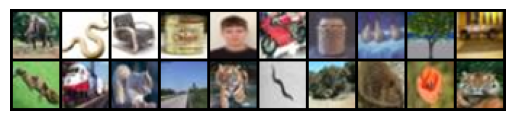

In [20]:
# Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader)) # Taking one batch from the dataloader
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Convolutional Autoencoder Network [35 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two networks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of the convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=19RqHo2PatyoFl7om8OUxBRb1uYAVGmhF)

The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In the encoder part of the network, use max pooling in each layer for decreasing the resolution by half. The stride size should be set to one for the convolution layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back.

In [21]:
class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, padding=0),

            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, padding=0)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Tanh activation
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = CifarAutoencoder().to(device)

from torchsummary import summary

print(model)
summary(model, (3, 32, 32))

CifarAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2)

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train the convolutional autoencoder. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![CIFAR Masking](https://drive.google.com/uc?export=view&id=1tlB0mNH4B5dKfokoe162qWgXgPDnOQi2)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [22]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch in train_dataloader:
            inputs= batch

            # Check if the inputs is a tuple
            if isinstance(inputs, tuple):
                inputs = inputs[0]

            # Move inputs and labels to the device
            inputs = inputs.to(device)

            # Check if the labels is a tuple
            #if isinstance(labels, tuple):
            #    labels = labels[0]

            #labels = labels.to(device)

            # Mask the input images
            masked_inputs = inputs.clone()
            masked_inputs[:, :, :, 16:32] = -1  # Set the columns from 16 to 32 as black pixels

            masked_inputs = masked_inputs.to(device)

            optimizer.zero_grad()

            outputs = model(masked_inputs)
            loss = loss_func(outputs, inputs)  # Use the original image as ground truth

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_dataloader)
        losses_per_epoch.append(epoch_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return losses_per_epoch


### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [23]:
def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    model.eval()

    total_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs = batch

            # Check if the inputs is a tuple
            if isinstance(inputs, tuple):
                inputs = inputs[0]
            # Check if the labels is a tuple
            #if isinstance(labels, tuple):
            #    labels = labels[0]

            # Mask the input images
            masked_inputs = inputs.clone()
            masked_inputs[:, :, :, 16:32] = -1  # Set the columns from 16 to 32 as black pixels

            inputs, masked_inputs = inputs.to(device), masked_inputs.to(device)

            #labels = labels.to(device)

            outputs = model(masked_inputs)
            loss = criterion(outputs, inputs)  # Use the original image as ground truth

            total_loss += loss.item()
            num_samples += inputs.size(0)

    mean_loss = total_loss / num_samples
    return mean_loss


### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. **Do not change the codes in the cell**.

In [24]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cpu()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the Model [10 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the mean square error that your model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



In [25]:
seed_everything(464)

model = CifarAutoencoder() ## Uncomment when the model is implemented
optimizer = optim.Adam(model.parameters(), lr=0.0002)
loss_func = nn.MSELoss()

history = train_model(model, train_dataloader, optimizer, loss_func, num_epochs=10)

evaluate_model(model, test_dataloader)

# TODO

Epoch 1/10, Loss: 0.1254
Epoch 2/10, Loss: 0.0855
Epoch 3/10, Loss: 0.0803
Epoch 4/10, Loss: 0.0778
Epoch 5/10, Loss: 0.0761
Epoch 6/10, Loss: 0.0749
Epoch 7/10, Loss: 0.0737
Epoch 8/10, Loss: 0.0731
Epoch 9/10, Loss: 0.0724
Epoch 10/10, Loss: 0.0720


0.00014460306689895766

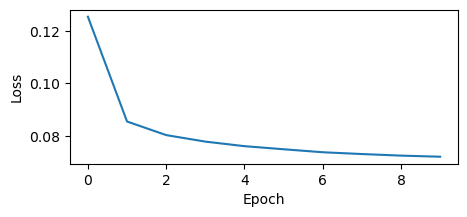

In [30]:
# Plot the training loss history
plt.figure(figsize=(5,2))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

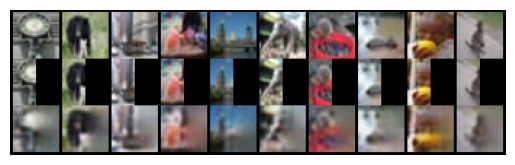

In [31]:
visualize_inpainting(model, test_dataset) ## Uncomment when the model is trained